# Example analysis instructions
 This demo is essentially a copy of the notebook that generates the results of the partial least squares model on the combinatorial data. Should you want to run this demo on your own data, make sure to load your dataframe and ensure that it contains columns 'is_buried', 'is_connected', 'is_close_to_as' and 'is_secondary', each storing indicator values of whether the corresponding variant belongs to that structural class (e.g. 'is_buried'=0 of a variant has only mutations that are exposed). Results can be generated by simply running all cells sequentially.

### Expected results
When running this notebook, the last cell should plot the differences in performance of the partial least squares model and show that variants with multiple mutations that are buried, closely connected with other residues or close to the active site, are harder to predict than their counterparts (i.e. exposed, loosely connected, far from the active site).

### Expected runtime
Running this notebook on a normal desktop computer should not take much longer than five minutes.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import KFold
import plotnine as p9

from predictability.models import PartialLeastSquares
from predictability.constants import BINARY_RESIDUE_FEATURES, DATA_ROOT
from predictability.plotting import assign_pretty_feature_names, color_mapping, feature_mapping

In [2]:
seed = 42

In [3]:
data = pd.read_csv(DATA_ROOT / "AMY_BACSU/combinatorials.csv")
property = "stain_activity"

In [4]:
experiment_results = {
    "fold": [],
    "feature": [],
    "belongs": [],
    "spearman_val": [],
    "model": [],
}
prediction_dfs = []
for feature in BINARY_RESIDUE_FEATURES:
    for belongs in [0, 1]:
        df = data[data[feature]==belongs].reset_index()
        k_fold = KFold(n_splits=10, shuffle=True, random_state=seed)
        for i, (train_inds, test_inds) in enumerate(k_fold.split(np.arange(len(df)))):
            split_ids = np.empty(len(df), dtype=object)
            split_ids[train_inds] = "train"
            split_ids[test_inds] = "valid"
            df["split"] = split_ids
            model = PartialLeastSquares()
            model.fit(df[df["split"] == "train"], property)
            predictions_val = model.predict(df[df["split"] == "valid"])
            spearman_val, _ = spearmanr(df[df["split"] == "valid"][property].values, predictions_val)
            experiment_results["fold"].append(i)
            experiment_results["feature"].append(feature)
            experiment_results["belongs"].append(belongs)
            experiment_results["spearman_val"].append(spearman_val)
            experiment_results["model"].append("PLS")

In [5]:
results_df = pd.DataFrame(experiment_results)
results_df["belongs"] = results_df["belongs"].astype(bool)
results_df["Feature label"] = results_df["belongs"].apply(lambda x: "Negative" if x==False else "Positive")
results_df["Feature"] = results_df["feature"].apply(assign_pretty_feature_names)
results_df["Structural characteristic"] = results_df[['Feature', 'Feature label']].apply(
    lambda x: feature_mapping[tuple(x)], axis=1
)
results_df = results_df.rename(columns={"spearman_val": "Test spearman"})
results_df["Structural characteristic"] = pd.Categorical(results_df["Structural characteristic"],
                                                     categories=["Buried", "Exposed", "Many contacts", "Few contacts",
                                                                 "Close to active site", "Distant to active site",
                                                                 "Part of helix or sheet", "Part of loop"],
                                                     ordered=True)

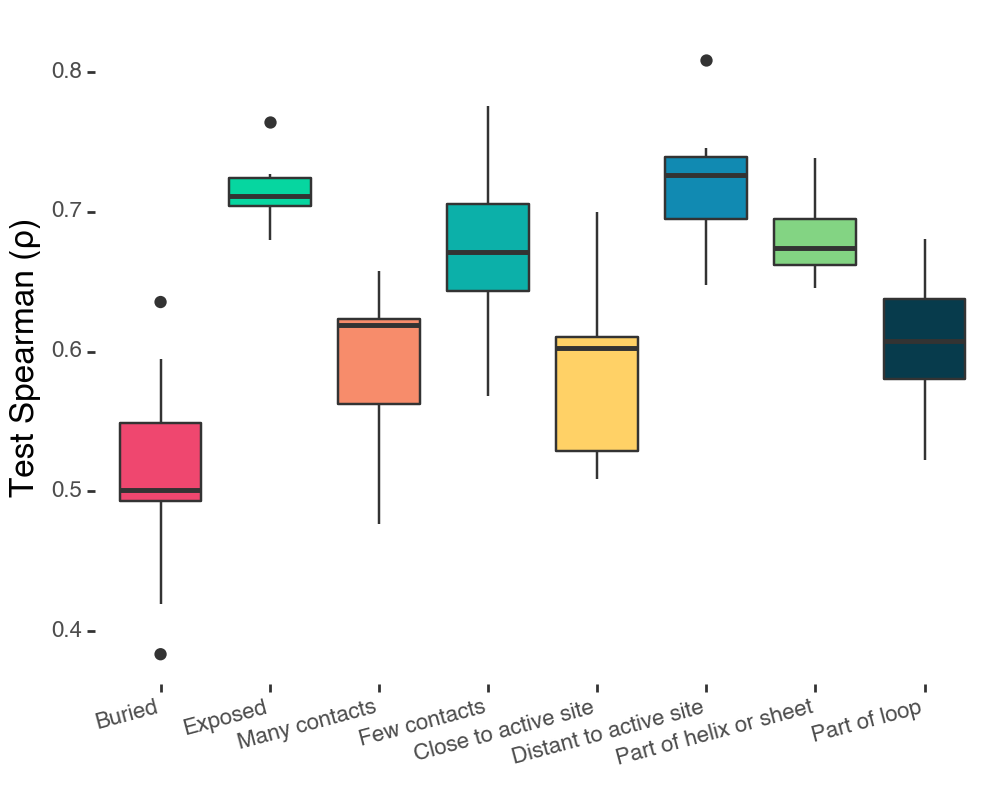

In [6]:
p = (
    p9.ggplot(
        results_df,
        p9.aes(
            "Structural characteristic",
            "Test spearman",
            fill="Structural characteristic",
        )
    )
    + p9.geom_boxplot(show_legend=False)
    + p9.theme(
        figure_size=(5, 4),
        axis_title_y=p9.element_text(text="Test Spearman (ρ)", size=12),
        axis_title_x=p9.element_text(size=12),
        axis_text_x=p9.element_text(rotation=15, ha="right", size=8),
        axis_text_y=p9.element_text(size=8),
        plot_background=p9.element_rect(fill='white'),
        panel_background=p9.element_rect(fill='white')
    )
    + p9.scale_fill_manual(values=color_mapping)
    + p9.labs(x="")
)
p.draw()
print(p)